In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
plt.style.use('../report_plots/report.mplstyle')


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


# Figure 8

In [2]:
def load_tc_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    tc_rates = data['tuning_curves_rates']  # (neurons, num_cov, steps)
    tc_FF = data['tuning_curves_FF']  # (neurons, num_cov, steps)
    tc_cov = data['tuning_curves_covariates']  # (num_cov, steps)
    
    return tc_rates, tc_FF, tc_cov

def tuning_index(hd_stat):
    """Compute the tuning index of a tuning curve with a given statistics of spike count distributions."""
    tc_max = np.max(hd_stat, axis=-1)
    tc_min = np.min(hd_stat, axis=-1)

    return (tc_max - tc_min) / (tc_max + tc_min)

def plot_TI_rate_vs_ff(features_rates, features_FF, labels, label_names, cov='hd', title=None, ax=None, colors=None, s=6, legendsize=6):
    
    covariates = ['hd', 'omega', 'speed', 'x', 'y', 'time']
    
    sorted_indices = np.argsort(labels)
    sorted_rates = features_rates[sorted_indices]
    sorted_FF = features_FF[sorted_indices]
    
    num_neurons_per_region = []
    for i, name in enumerate(label_names):
        num_neurons_per_region.append(np.where(labels==i)[0].size)
    cum_neurons = np.cumsum(np.array(num_neurons_per_region))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    
    # define the colormap
    if colors is None:
        colors = list(matplotlib.colors.BASE_COLORS)
    
    if ax is None:
        _, ax = plt.subplots()
    for i, label in enumerate(label_names):
        ax.scatter(sorted_rates[cum_neurons[i]:cum_neurons[i+1], covariates.index(cov)], sorted_FF[cum_neurons[i]:cum_neurons[i+1], covariates.index(cov)], c=colors[i], label=label, alpha=0.5, s=s)
    
    if title is not None:
        ax.set_title(title)

In [3]:
tc_datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'
datadir = data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

phase='wake'
bin_size=160
single_spikes=False

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

num_hdc = {}
num_nonhdc = {}
features_rates = np.empty((0, 6))  # we have 6 covariates, so 6 features
features_FF = np.empty((0, 6))

labels_brain_regions = np.empty(0)

for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        dataset = HDC.get_dataset(mouse_id, session_id, phase, 'hdc', bin_size, single_spikes, path=data_dir)
        neuron_regions = dataset['metainfo']['neuron_regions']
        labels_brain_regions = np.concatenate((labels_brain_regions, neuron_regions))
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(tc_datadir, mouse_id, session_id, subset)
            ti_rates = tuning_index(tc_rates)  # (neurons, num_cov)
            ti_FF = tuning_index(tc_FF)
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = ti_rates.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = ti_rates.shape[0]
                
            features_rates = np.concatenate((features_rates, ti_rates), axis=0)
            features_FF = np.concatenate((features_FF, ti_FF), axis=0)

print(features_rates.shape)

labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

labels_mice = []

for i, mouse_id in enumerate(mice_sessions.keys()):
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])
        
filter_hdc = np.array(labels_hdc).astype(bool)
print(filter_hdc.shape)

mice_names = list(mice_sessions.keys())
for i, name in enumerate(mice_names):
    ind = name.rfind('e')
    new_name = name[:ind+1] + ' #' + name[ind+1:] 
    mice_names[i] = new_name
    
print(mice_names)

units:  85  hdc units:  22
units:  21  hdc units:  2
units:  46  hdc units:  7
units:  50  hdc units:  7
units:  55  hdc units:  5
units:  59  hdc units:  7
units:  11  hdc units:  2
units:  13  hdc units:  4
units:  17  hdc units:  4
units:  22  hdc units:  6
units:  28  hdc units:  5
units:  40  hdc units:  11
units:  43  hdc units:  11
units:  36  hdc units:  10
units:  32  hdc units:  5
units:  33  hdc units:  11
units:  56  hdc units:  14
(647, 6)
(647,)
['Mouse #12', 'Mouse #17', 'Mouse #20', 'Mouse #24', 'Mouse #25', 'Mouse #28']


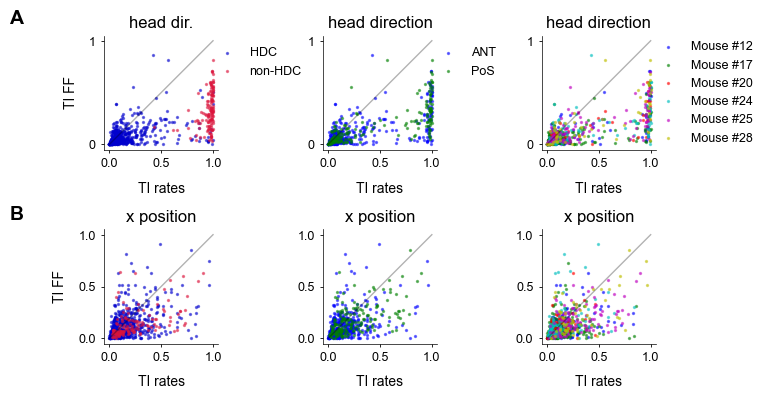

In [5]:
s=2  # size of dots on figures
legendsize=9

fig = plt.figure(figsize=(8,4))

gs = gridspec.GridSpec(2, 3, fig, hspace=0.7, wspace=0.2)

ax = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[1,0])]
titles = ['head dir.', 'x position']
for i, cov in enumerate(['hd', 'x']):
    ax[i].set_box_aspect(1)
    ax[i].plot([0,1], [0,1], color='black', alpha=0.3)
    plot_TI_rate_vs_ff(features_rates, features_FF, np.array(labels_hdc), ['HDC', 'non-HDC'], cov, f'{titles[i]}', ax[i], colors=['mediumblue', 'crimson'], s=s)
    ax[i].set_ylabel('TI FF')

    if i==0:
        ax[i].set_yticks(ticks=[0, 1])
        ax[i].legend(prop={'size': legendsize}, bbox_to_anchor=(1.35, 1), loc='upper center', frameon=False)
    
    ax[i].set_xlabel('TI rates')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    

ax = [fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1,1])]
titles = ['head direction', 'x position']
for i, cov in enumerate(['hd', 'x']):
    ax[i].set_box_aspect(1)
    ax[i].plot([0,1], [0,1], color='black', alpha=0.3)
    plot_TI_rate_vs_ff(features_rates, features_FF, labels_brain_regions, ['ANT', 'PoS'], cov, f'{titles[i]}', ax[i], s=s)
    if i==0:
        ax[i].set_yticks(ticks=[0, 1])
        ax[i].legend(prop={'size': legendsize}, loc='upper center', bbox_to_anchor=(1.25, 1), frameon=False)
    ax[i].set_xlabel('TI rates')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)



ax = [fig.add_subplot(gs[0,2]), fig.add_subplot(gs[1,2])]
titles = ['head direction', 'x position']
for i, cov in enumerate(['hd', 'x']):
    ax[i].set_box_aspect(1)
    ax[i].plot([0,1], [0,1], color='black', alpha=0.3)
    plot_TI_rate_vs_ff(features_rates, features_FF, np.array(labels_mice), mice_names, cov, f'{titles[i]}', ax[i], s=s)
    if i==0:
        ax[i].set_yticks(ticks=[0, 1])
        ax[i].legend(prop={'size': legendsize}, loc='center left', bbox_to_anchor=(0.90, 0.5), frameon=False)
    
    ax[i].set_xlabel('TI rates')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

fig.text(0.05, 0.91, 'A', transform=fig.transFigure, size=14, fontweight='bold')
fig.text(0.05, 0.42, 'B', transform=fig.transFigure, size=14, fontweight='bold')

fig.savefig("/homes/vn283/UCM-interpret/figures/tuning_basic.pdf", format="pdf", bbox_inches="tight")